# Introduction - Using COSINE Metric

In this notebook we demonstrate the use of **LSI (Latent Semantic Indexing)** technique of Information Retrieval context to make trace link recovery between Features and Bug Reports.

We model our study as follows:

* Each bug report title, summary and description compose a single query.
* We use each feature description and title as an entire document that must be returned to the query made

This notebook follows the analysis made in **oracle_v2_analysis**, where we obtained an Cohen's kappa score of _0.41_ between the answers of the researcher and the answers of the volunteers.

# Import Libraries

In [1]:
from mod_finder_util import mod_finder_util
mod_finder_util.add_modules_origin_search_path()

import pandas as pd
import pprint

from modules.models_runner.feat_br_models_runner import Feat_BR_Models_Runner
from modules.utils import aux_functions
from modules.utils import model_evaluator as m_eval
from modules.utils import firefox_dataset_p2 as fd
from modules.utils import similarity_measures as sm

from matplotlib import pyplot as plt

import warnings; warnings.simplefilter('ignore')

# Load Datasets

In [2]:
bugreports = fd.Datasets.read_selected_bugreports_df()
features = fd.Datasets.read_features_df()
br_2_features_matrix_final = fd.Feat_BR_Oracles.read_br_2_features_matrix_final_df()

SelectedBugReports.shape: (91, 18)
Features.shape: (21, 8)
BR_2_Features Matrix Final.shape: (91, 4)


# Running LSI Model - Exp-Vol UNION Oracle

In [3]:
models_runner_1 = Feat_BR_Models_Runner()

lsi_model_1 = models_runner_1.run_lsi_model()

evaluator_1 = m_eval.ModelEvaluator(oracle=fd.Feat_BR_Oracles.read_feat_br_expert_volunteers_union_df().T)

sim_thresh = 0.0

lsi_eval_t1 = evaluator_1.evaluate_model(model=lsi_model_1, top_value=1, sim_threshold=sim_thresh)
lsi_eval_t3 = evaluator_1.evaluate_model(model=lsi_model_1, top_value=3, sim_threshold=sim_thresh)
lsi_eval_t5 = evaluator_1.evaluate_model(model=lsi_model_1, top_value=5, sim_threshold=sim_thresh)
lsi_eval_t10 = evaluator_1.evaluate_model(model=lsi_model_1, top_value=10, sim_threshold=sim_thresh)

Features.shape: (21, 8)
SelectedBugReports.shape: (91, 18)
Running LSI model -----
Expert and Volunteers Matrix UNION.shape: (91, 21)


# Similarity Matrix

In [4]:
aux_functions.highlight_df(lsi_model_1.get_sim_matrix().iloc[0:23, 0:14])

Bug_Number,1248267,1248268,1257087,1264988,1267480,1267501,1269348,1269485,1270274,1270983,1271607,1276120,1277937,1278388
feat_name,,,,,,,,,,,,,,
new_awesome_bar,0.320741,0.568394,0.671144,0.931044,0.164355,0.631198,0.181918,0.640709,0.164355,0.29042,0.419515,0.624393,0.586379,0.153829
windows_child_mode,0.0561108,0.406251,0.165129,0.0772069,0.212747,0.206565,0.126042,0.223301,0.212747,0.0972844,0.335712,0.317819,0.216041,0.199122
apz_async_scrolling,0.00122383,0.0295661,0.047032,0.0630632,0.042386,0.260099,0.00498738,0.173511,0.042386,0.0193822,0.134189,0.0447946,0.0756162,0.0396715
browser_customization,0.0252172,0.279508,0.057479,0.139368,0.520398,0.0431226,0.102766,0.0478245,0.520398,0.237966,0.210116,0.0615864,0.233519,0.48707
pdf_viewer,0.00557269,0.048238,0.0127021,0.0170318,0.193004,0.00952956,0.0227099,0.0105686,0.193004,0.0882564,0.00697391,0.022841,0.131052,0.180644
context_menu,0.971288,0.429624,0.44198,0.131035,0.0496182,0.33884,0.0514961,0.430191,0.0496182,0.889817,0.326,0.351809,0.111389,0.0464405
w10_comp,0.190804,0.318948,0.220759,0.23969,0.433016,0.491275,0.179211,0.514725,0.433016,0.372015,0.785257,0.714008,0.468447,0.405285
tts_in_desktop,0.0175157,0.202421,0.0399245,0.0898432,0.400903,0.59806,0.0713803,0.528585,0.400903,0.183324,0.125994,0.0474448,0.260753,0.375228
tts_in_rm,0.0231009,0.256051,0.0526551,0.127672,0.476724,0.430549,0.0941412,0.433093,0.476724,0.217995,0.192482,0.218953,0.259802,0.446193


# Analysis of BR x Feat Generated Traces

In [5]:
def get_features(br_id, matrix):
    features_ids = ""
    matrix = matrix.T
      
    for col in matrix.columns:
        if matrix.at[br_id, col] == 1:
            if features_ids == "":
                features_ids = str(matrix.columns.get_loc(col) + 1)
            else:
                features_ids = features_ids + " " + str(matrix.columns.get_loc(col) + 1)
    
    return features_ids

In [9]:
cols = ['Features_IDs_lsi_t1_m','Features_IDs_lsi_t3_m','Features_IDs_lsi_t5_m','Features_IDs_lsi_t10_m','Features_IDs_orc']

br_2_features_matrix_final['Features_IDs_lsi_t1_m'] = list(bugreports.apply(lambda row : get_features(row['Bug_Number'], lsi_eval_t1['trace_links_df']), axis=1))
br_2_features_matrix_final['Features_IDs_lsi_t3_m'] = list(bugreports.apply(lambda row : get_features(row['Bug_Number'], lsi_eval_t3['trace_links_df']), axis=1))
br_2_features_matrix_final['Features_IDs_lsi_t5_m'] = list(bugreports.apply(lambda row : get_features(row['Bug_Number'], lsi_eval_t5['trace_links_df']), axis=1))
br_2_features_matrix_final['Features_IDs_lsi_t10_m'] = list(bugreports.apply(lambda row : get_features(row['Bug_Number'], lsi_eval_t10['trace_links_df']), axis=1))
br_2_features_matrix_final['Features_IDs_orc'] = list(bugreports.apply(lambda row : get_features(row['Bug_Number'], evaluator_1.get_oracle_df()), axis=1))
br_2_features_matrix_final.replace(" ", "", inplace=True)

br_2_features_matrix_final['f_names_lsi_t1'] = br_2_features_matrix_final.Features_IDs_lsi_t1_m.apply(lambda row : [features[features.Feature_Number == int(f_id)].Feature_Shortname for f_id in row.split(" ") if f_id != ""])
br_2_features_matrix_final['f_names_lsi_t3'] = br_2_features_matrix_final.Features_IDs_lsi_t3_m.apply(lambda row : [features[features.Feature_Number == int(f_id)].Feature_Shortname for f_id in row.split(" ") if f_id != ""])
br_2_features_matrix_final['f_names_lsi_t5'] = br_2_features_matrix_final.Features_IDs_lsi_t5_m.apply(lambda row : [features[features.Feature_Number == int(f_id)].Feature_Shortname for f_id in row.split(" ") if f_id != ""])
br_2_features_matrix_final['f_names_lsi_t10'] = br_2_features_matrix_final.Features_IDs_lsi_t10_m.apply(lambda row : [features[features.Feature_Number == int(f_id)].Feature_Shortname for f_id in row.split(" ") if f_id != ""])
br_2_features_matrix_final['f_names_orc'] = br_2_features_matrix_final.Features_IDs_orc.apply(lambda row : [features[features.Feature_Number == int(f_id)].Feature_Shortname for f_id in row.split(" ") if f_id != ""])
br_2_features_matrix_final['bug_title'] = br_2_features_matrix_final.apply(lambda row : bugreports[bugreports.Bug_Number == int(row.name)].Summary.values[0], axis=1)

cols2 = ['f_names_orc','f_names_lsi_t1','f_names_lsi_t3','f_names_lsi_t5','f_names_lsi_t10']

br_2_features_matrix_final[cols2].head(10)

,f_names_orc,f_names_lsi_t1,f_names_lsi_t3,f_names_lsi_t5,f_names_lsi_t10
Bug_Number,,,,,
1248267,[[context_menu]],[[context_menu]],"[[new_awesome_bar], [context_menu], [w10_comp]]","[[new_awesome_bar], [windows_child_mode], [con...","[[new_awesome_bar], [windows_child_mode], [bro..."
1248268,[[browser_customization]],[[new_awesome_bar]],"[[new_awesome_bar], [context_menu], [webgl2]]","[[new_awesome_bar], [windows_child_mode], [con...","[[new_awesome_bar], [windows_child_mode], [bro..."
1257087,[],[[new_awesome_bar]],"[[new_awesome_bar], [context_menu], [pointer_l...","[[new_awesome_bar], [windows_child_mode], [con...","[[new_awesome_bar], [windows_child_mode], [bro..."
1264988,[[new_awesome_bar]],[[new_awesome_bar]],"[[new_awesome_bar], [w10_comp], [notificationb...","[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [browser_customization], [..."
1267480,[],[[webgl2]],"[[browser_customization], [tts_in_rm], [webgl2]]","[[browser_customization], [w10_comp], [tts_in_...","[[windows_child_mode], [browser_customization]..."
1267501,[[apz_async_scrolling]],[[new_awesome_bar]],"[[new_awesome_bar], [w10_comp], [tts_in_desktop]]","[[new_awesome_bar], [context_menu], [w10_comp]...","[[new_awesome_bar], [windows_child_mode], [apz..."
1269348,[],[[indicator_device_perm]],"[[new_awesome_bar], [w10_comp], [indicator_dev...","[[new_awesome_bar], [w10_comp], [indicator_dev...","[[new_awesome_bar], [windows_child_mode], [bro..."
1269485,[[apz_async_scrolling]],[[new_awesome_bar]],"[[new_awesome_bar], [w10_comp], [tts_in_desktop]]","[[new_awesome_bar], [context_menu], [w10_comp]...","[[new_awesome_bar], [windows_child_mode], [apz..."
1270274,[],[[webgl2]],"[[browser_customization], [tts_in_rm], [webgl2]]","[[browser_customization], [w10_comp], [tts_in_...","[[windows_child_mode], [browser_customization]..."


# Analysis of Precision and Recall

In [7]:
evaluator_1.run_evaluator(model=lsi_model_1, top_values=[1,3,5,10], sim_thresholds=[(sm.SimilarityMeasure.COSINE, s_thresh/10) for s_thresh in range(0,10)])

Evaluating LSI Model ----- 


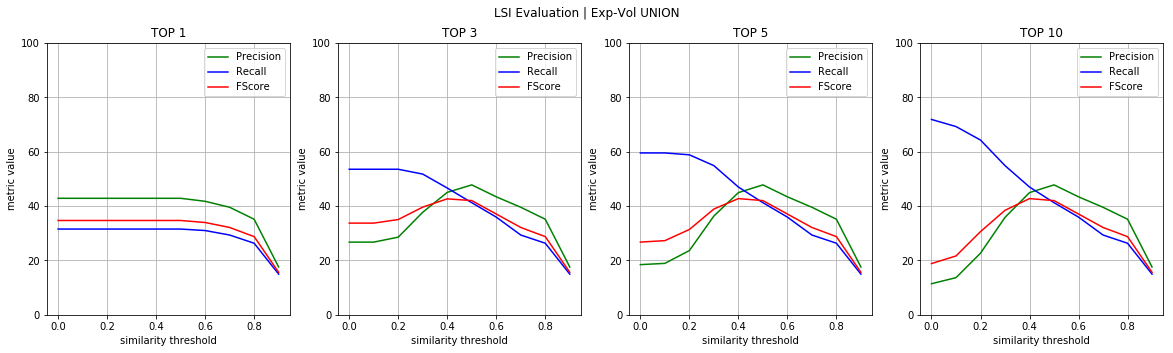

In [8]:
results = evaluator_1.get_evaluations_df()
evaluator_1.plot_evaluations_2(title='LSI Evaluation | Exp-Vol UNION', results=results)

# Analysis of False Positives

# Analysis of False Negatives